In [1]:
import os as os
from rpy2 import *
# os.environ["R_HOME"]="C:/Program Files/R/R-3.2.3/"
# os.environ["R_USER"]="laoj"
%load_ext rpy2.ipython
%matplotlib inline

In [2]:
%%R
###########################################################
## Bayesian (rjags)
rm(list = ls())

# Choose a condition:
condi <- 1
# Choose a model: 1 - estimate using two linked beta; 
#                 2 - estimate using Dirichlet
modelmod <- 1


library(R2jags)
library(ggplot2)
library(ggExtra)

dat = read.csv("TestPhase.csv")

## Expression bias
FixDur <- dat$fixDur
Emo <- dat$Emo2
Famil <- dat$Famil
Grp <- dat$Grp

# The datasets:
x <- FixDur[Emo == "FEAR"]
y <- FixDur[Emo == "HAPPY"]
label1 <- "FEAR"
label2 <- "HAPPY"


n <- length(x) # number of people/units measured
if (modelmod == 1) {
  dur <- (x + y) / 5
  x1 <- x / (x + y)
  
  x1[x1 == 1] = .999999999999999
  dur[dur == 1] = .999999999999999
  x1[x1 == 0] = 1 - .999999999999999
  dur[dur == 0] = 1 - .999999999999999
  
  data <- list(x = x1, n = n,dur = dur) # to be passed on to JAGS
  myinits <- list(list(
    phi1 = 2.9,a1 = 0,phi2 = 2.9,a2 = 0
  ))
  
  # parameters to be monitored:
  parameters <- c("alpha1", "beta1","mu1","alpha2", "beta2","mu2")
  
  # The following command calls JAGS with specific options.
  # For a detailed description see the R2jags documentation.
  samples <- jags(
    data, inits = myinits, parameters,
    model.file = "model1.txt", n.chains = 1, n.iter = 10000,
    n.burnin = 500, n.thin = 1, DIC = T
  )
  
  durtmp <- samples$BUGSoutput$sims.list$mu1
  durtrace <- durtmp * 5
  xtmp <- samples$BUGSoutput$sims.list$mu2
  xtrace <- durtrace * xtmp
  ytrace <- durtrace - xtrace
} else {
  z = 5 - x - y
  x[x <= 0] = 5 - 4.999999999999999
  y[y <= 0] = 5 - 4.999999999999999
  z[z <= 0] = 5 - 4.999999999999999
  
  data <- list(x = x, y = y, z = z, n = n) # to be passed on to JAGS
  myinits <- list(list(alpha1 = mean(x),alpha2 = mean(y)))
  
  # parameters to be monitored:
  parameters <- c("alpha1", "alpha2", "alpha3")
  
  # The following command calls JAGS with specific options.
  # For a detailed description see the R2jags documentation.
  samples <- jags(
    data, inits = myinits, parameters,
    model.file = "model2.txt", n.chains = 1, n.iter = 10000,
    n.burnin = 500, n.thin = 1, DIC = T
  )
  
  xtrace <- samples$BUGSoutput$sims.list$alpha1
  ytrace <- samples$BUGSoutput$sims.list$alpha2
}


/usr/local/lib/python3.4/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: rjags

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python3.4/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: coda

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python3.4/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Linked to JAGS 4.1.0

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python3.4/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loaded modules: basemod,bugs

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python3.4/dist-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘R2jags’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python3.4/dist-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is mask

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 612
   Unobserved stochastic nodes: 4
   Total graph size: 637

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |**************************************************| 100%


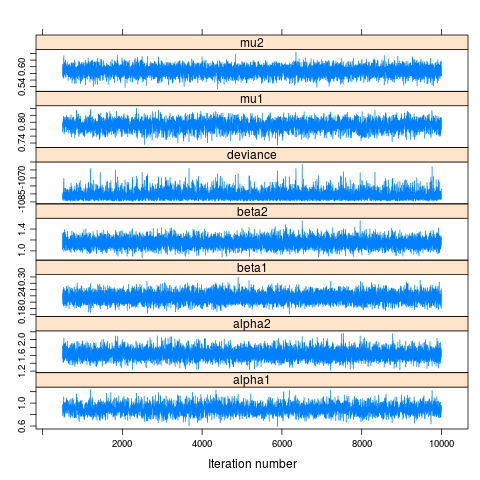

In [3]:
%%R
library(lattice)
# Additional option: use some plots in coda
# first use as.mcmmc to convert rjags object into mcmc.list:
samples.mcmc <- as.mcmc(samples)
# then use the plotting methods from coda:
xyplot(samples.mcmc)

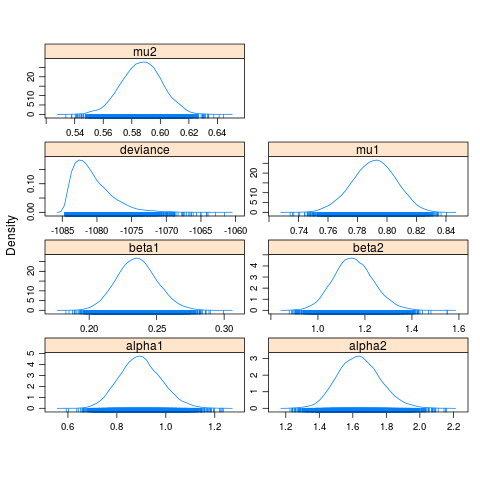

In [4]:
%%R 
densityplot(samples.mcmc)

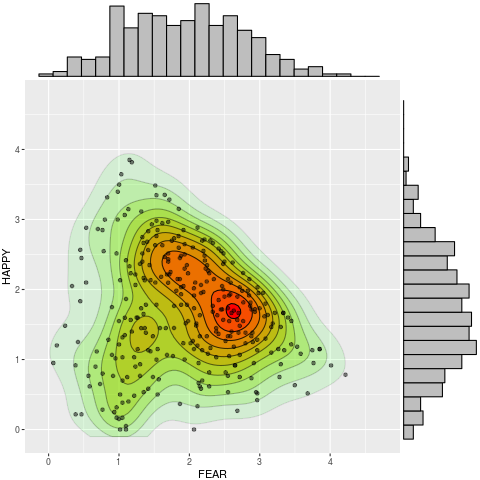

In [5]:
%%R 
library(ggplot2)
library(ggExtra)
# create a ggplot2 scatterplot
df2 <- data.frame(x = xtrace, y = ytrace)
df <- data.frame(x = x, y = y)
p <- ggplot(df,aes(x = x,y = y)) +
  stat_density2d(aes(fill = ..level..,alpha = ..level..),geom = 'polygon',colour =
                   'black') +
  scale_fill_continuous(low = "green",high = "red") +
  guides(alpha = "none")  + geom_point(colour = "black",alpha = 0.5) +
  xlab(label1) + ylab(label2) + xlim(-.1, 4.75) + ylim(-.1, 4.75) + 
  theme(legend.position = "none")
# add marginal histograms
ggMarginal(p, type = "histogram",binwidth = 5 / 25)

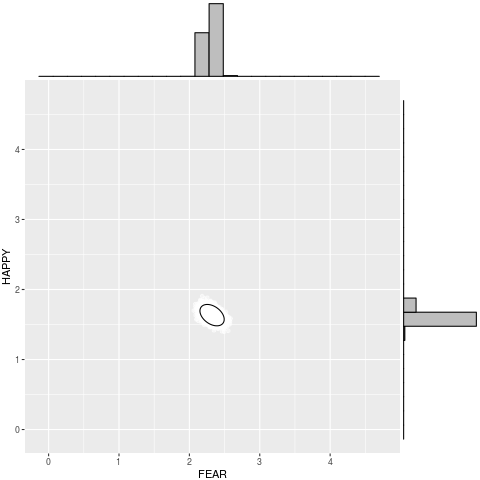

In [6]:
%%R
p2 <- ggplot(df2,aes(x = x,y = y)) + geom_point(colour = "white",alpha = 0.5) + stat_ellipse(type = "norm") +
  xlab(label1) + ylab(label2) + xlim(-.1, 4.75) + ylim(-.1, 4.75)
ggMarginal(p2, type = "histogram",binwidth = 5 / 25)

In [7]:
%%R
###########################################################
## Bayesian (rjags)
rm(list = ls())

# Choose a condition:
condi <- 1
# Choose a model: 1 - estimate using two linked beta; 
#                 2 - estimate using Dirichlet
modelmod <- 1


library(R2jags)
library(ggplot2)
library(ggExtra)

dat = read.csv("TestPhase.csv")

## Expression bias
FixDur <- dat$fixDur
Emo <- dat$Emo2
Famil <- dat$Famil
Grp <- dat$Grp

# The datasets:
x <- FixDur[Famil == "famil"]
y <- FixDur[Famil == "novel"]
label1 <- "Famil"
label2 <- "Novel"


n <- length(x) # number of people/units measured
if (modelmod == 1) {
  dur <- (x + y) / 5
  x1 <- x / (x + y)
  
  x1[x1 == 1] = .999999999999999
  dur[dur == 1] = .999999999999999
  x1[x1 == 0] = 1 - .999999999999999
  dur[dur == 0] = 1 - .999999999999999
  
  data <- list(x = x1, n = n,dur = dur) # to be passed on to JAGS
  myinits <- list(list(
    phi1 = 2.9,a1 = 0,phi2 = 2.9,a2 = 0
  ))
  
  # parameters to be monitored:
  parameters <- c("alpha1", "beta1","mu1","alpha2", "beta2","mu2")
  
  # The following command calls JAGS with specific options.
  # For a detailed description see the R2jags documentation.
  samples <- jags(
    data, inits = myinits, parameters,
    model.file = "model1.txt", n.chains = 1, n.iter = 10000,
    n.burnin = 500, n.thin = 1, DIC = T
  )
  
  durtmp <- samples$BUGSoutput$sims.list$mu1
  durtrace <- durtmp * 5
  xtmp <- samples$BUGSoutput$sims.list$mu2
  xtrace <- durtrace * xtmp
  ytrace <- durtrace - xtrace
} else {
  z = 5 - x - y
  x[x <= 0] = 5 - 4.999999999999999
  y[y <= 0] = 5 - 4.999999999999999
  z[z <= 0] = 5 - 4.999999999999999
  
  data <- list(x = x, y = y, z = z, n = n) # to be passed on to JAGS
  myinits <- list(list(alpha1 = mean(x),alpha2 = mean(y)))
  
  # parameters to be monitored:
  parameters <- c("alpha1", "alpha2", "alpha3")
  
  # The following command calls JAGS with specific options.
  # For a detailed description see the R2jags documentation.
  samples <- jags(
    data, inits = myinits, parameters,
    model.file = "model2.txt", n.chains = 1, n.iter = 10000,
    n.burnin = 500, n.thin = 1, DIC = T
  )
  
  xtrace <- samples$BUGSoutput$sims.list$alpha1
  ytrace <- samples$BUGSoutput$sims.list$alpha2
}


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 612
   Unobserved stochastic nodes: 4
   Total graph size: 637

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |**************************************************| 100%


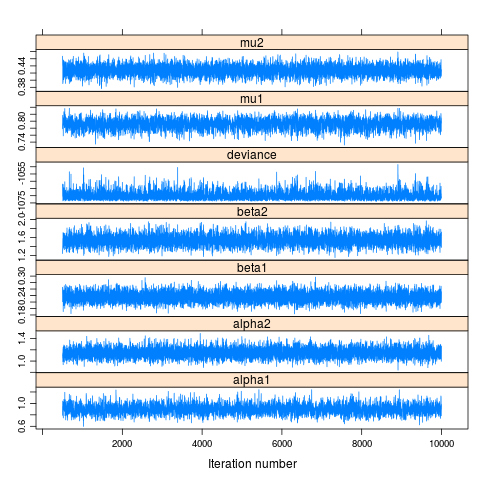

In [8]:
%%R
library(lattice)
# Additional option: use some plots in coda
# first use as.mcmmc to convert rjags object into mcmc.list:
samples.mcmc <- as.mcmc(samples)
# then use the plotting methods from coda:
xyplot(samples.mcmc)

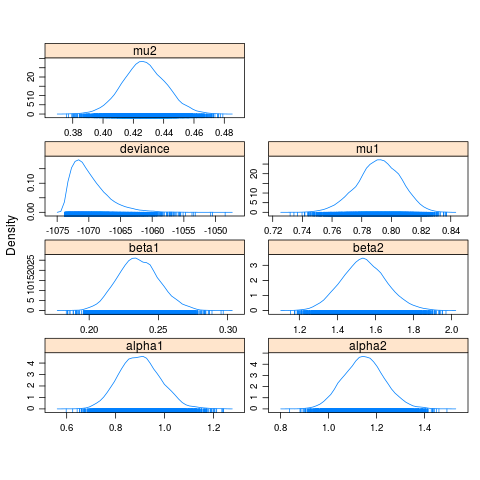

In [9]:
%%R 
densityplot(samples.mcmc)

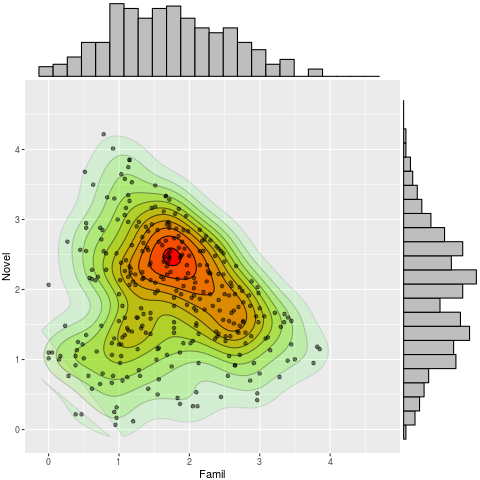

In [10]:
%%R 
library(ggplot2)
library(ggExtra)
# create a ggplot2 scatterplot
df2 <- data.frame(x = xtrace, y = ytrace)
df <- data.frame(x = x, y = y)
p <- ggplot(df,aes(x = x,y = y)) +
  stat_density2d(aes(fill = ..level..,alpha = ..level..),geom = 'polygon',colour =
                   'black') +
  scale_fill_continuous(low = "green",high = "red") +
  guides(alpha = "none")  + geom_point(colour = "black",alpha = 0.5) +
  xlab(label1) + ylab(label2) + xlim(-.1, 4.75) + ylim(-.1, 4.75) + 
  theme(legend.position = "none")
# add marginal histograms
ggMarginal(p, type = "histogram",binwidth = 5 / 25)

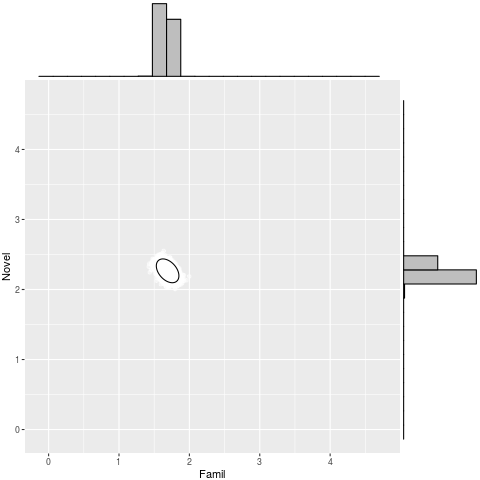

In [11]:
%%R
p2 <- ggplot(df2,aes(x = x,y = y)) + geom_point(colour = "white",alpha = 0.5) + stat_ellipse(type = "norm") +
  xlab(label1) + ylab(label2) + xlim(-.1, 4.75) + ylim(-.1, 4.75)
ggMarginal(p2, type = "histogram",binwidth = 5 / 25)